In [26]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [64]:
import numpy as np
import pandas as pd

In [28]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [29]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func,inspect

In [30]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [31]:
# reflect an existing database into a new model

Base = automap_base()

# reflect the tables

Base.prepare(engine,reflect = True)

In [32]:
# We can view all of the classes that automap found

inspector = inspect(engine)
tables = inspector.get_table_names()

print(tables)


['measurement', 'station']


In [33]:
# Display Column Names 

station_c=inspector.get_columns('station')
for column in station_c:
    print(column['name'],column['type'])
    
print("-------------------------------------")


measurement_c=inspector.get_columns("measurement")
for column in measurement_c:
    print(column["name"],column["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT
-------------------------------------
id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [34]:
# Save references to each table

Station = Base.classes.station
Measurement = Base.classes.measurement


In [35]:
# Create our session (link) from Python to the DB

session = Session(engine)


# Exploratory Climate Analysis

2017-08-23
Measured last date: 2017-08-23 00:00:00
To query the above: 2016-08-23


Text(0.5, 1.0, 'Precipitation Data from 2016-08-23 to 2017-08-23')

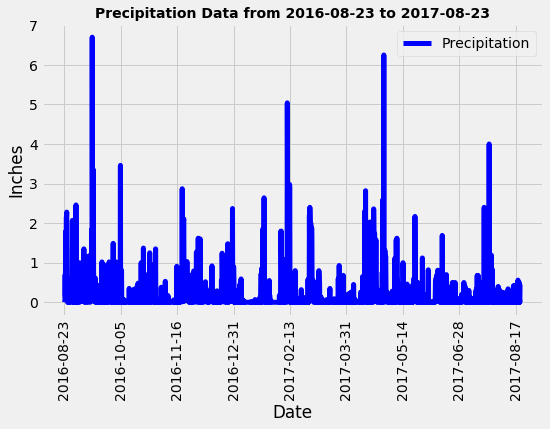

In [87]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results

prcp_lastyear = pd.DataFrame(session.query(Measurement.date,Measurement.prcp)
                             .filter(Measurement.date >= dt.date(2016,8,23)),columns=['Date','Precipitation'])

prcp_lastyear.head()
# Calculate the date 1 year ago from the last data point in the database

last_data_point = session.query(Measurement.date).order_by(Measurement.date.desc()).first()[0]
print(last_data_point)
last_date = dt.datetime.strptime(last_data_point , "%Y-%m-%d")
print(f"Measured last date: {last_date}")
first_date = dt.date(last_date.year-1,last_date.month,last_date.day)
print(f"To query the above: {first_date}")

# Perform a query to retrieve the data and precipitation scores

scores = session.query(Measurement.date,Measurement.prcp).filter(Measurement.date >= first_date)

# Save the query results as a Pandas DataFrame and set the index to the date column

scores_df = pd.DataFrame(scores,columns=['Date','Precipitation']).set_index('Date')
scores_df.head()

scores_df = scores_df.dropna()

# Sort the dataframe by date

scores_df=scores_df.sort_index()
scores_df

# Use Pandas Plotting with Matplotlib to plot the data

graph = scores_df.plot(rot=90,color='Blue',figsize=(8,5),linewidth =5)
graph.set_xlabel('Date')
graph.set_ylabel('Inches')
graph.set_title('Precipitation Data from 2016-08-23 to 2017-08-23',fontsize = 14,fontweight='bold')


In [88]:
# Use Pandas to calcualte the summary statistics for the precipitation data

scores_df.describe()


,Precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [90]:
# Design a query to show how many stations are available in this dataset?

total_stations = session.query(Station.station).count()
print(f"There are a total of {total_stations} stations in this dataset")


There are a total of 9 stations in this dataset


In [112]:
# What are the most active stations? (i.e. what stations have the most rows)?

active_stations = pd.DataFrame(session.query(Measurement.station,Measurement.prcp),columns=['Station','Observation Counts']).groupby('Station').count().sort_values('Observation Counts', ascending = False)

 
active_station = active_stations.index[0]
print(f"{active_station} is the most active station with 2772 observations.")
                               
                            

# List the stations and the counts in descending order.
active_stations

USC00519281 is the most active station with 2772 observations.


,Observation Counts
Station,
USC00519281,2772
USC00513117,2696
USC00519397,2685
USC00519523,2572
USC00516128,2484
USC00514830,1937
USC00511918,1932
USC00517948,683
USC00518838,342


In [125]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?

active_station = active_stations.index[0]

active_min_temp, active_max_temp,active_avg_temp = session.query(func.min(Measurement.tobs),\
                                                         func.max(Measurement.tobs),\
                                                         func.avg(Measurement.tobs))\
                                                         .filter(Measurement.station == active_station)\
                                                          .all()[0]

print(f"The highest temperature of the {active_station} is {active_max_temp},\n\
The lowest temperature of the {active_station} is {active_min_temp},\n\
The average temperature of the {active_station} is {round(active_avg_temp,1)}\
")



The highest temperature of the USC00519281 is 85.0,
The lowest temperature of the USC00519281 is 54.0,
The average temperature of the USC00519281 is 71.7


,Date,Temperature Observation
0,2016-08-23,77.0
1,2016-08-24,77.0
2,2016-08-25,80.0
3,2016-08-26,80.0
4,2016-08-27,75.0
...,...,...
347,2017-08-14,77.0
348,2017-08-15,77.0
349,2017-08-16,76.0
350,2017-08-17,76.0


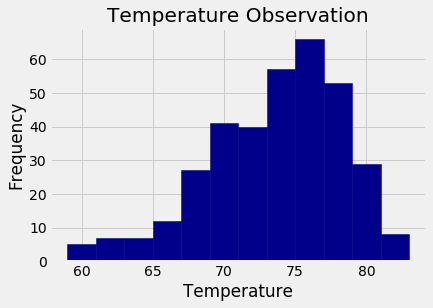

In [139]:
# Choose the station with the highest number of temperature observations

# Query the last 12 months of temperature observation data for this station and plot the results as a histogram


lastyear_tobs = pd.DataFrame(session.query(Measurement.date, Measurement.tobs)\
                .filter(Measurement.date >= first_date)\
                .filter(Measurement.station==active_station),\
                columns=['Date','Temperature Observation'])

lastyear_tobs= lastyear_tobs.dropna()
lastyear_tobs

hist_temp = lastyear_tobs.hist(bins =12, facecolor='DarkBlue', edgecolor= "DarkBlue")
for ht in hist_temp.flatten():
    ht.set_xlabel("Temperature")
    ht.set_ylabel("Frequency")
    
                                
            
                
lastyear_tobs

## Bonus Challenge Assignment

In [141]:
# TEMPERATURE ANALYSIS I

#Read and save csv data

station_df = pd.read_csv("Resources/hawaii_stations.csv") 
measurement_df = pd.read_csv("Resources/hawaii_measurements.csv")
measurement_df





,station,date,prcp,tobs
0,USC00519397,2010-01-01,0.08,65
1,USC00519397,2010-01-02,0.00,63
2,USC00519397,2010-01-03,0.00,74
3,USC00519397,2010-01-04,0.00,76
4,USC00519397,2010-01-06,NaN,73
...,...,...,...,...
19545,USC00516128,2017-08-19,0.09,71
19546,USC00516128,2017-08-20,NaN,78
19547,USC00516128,2017-08-21,0.56,76
19548,USC00516128,2017-08-22,0.50,76


In [144]:
#Remove null 

station_df = station_df.dropna()
measurement_df = measurement_df.dropna()

measurement_df

,station,date,prcp,tobs
0,USC00519397,2010-01-01,0.08,65
1,USC00519397,2010-01-02,0.00,63
2,USC00519397,2010-01-03,0.00,74
3,USC00519397,2010-01-04,0.00,76
5,USC00519397,2010-01-07,0.06,70
...,...,...,...,...
19543,USC00516128,2017-08-17,0.13,72
19545,USC00516128,2017-08-19,0.09,71
19547,USC00516128,2017-08-21,0.56,76
19548,USC00516128,2017-08-22,0.50,76


In [202]:
#Temperature Difference Between June and December


query_june="06"

june_avg=session.query(func.avg(Measurement.tobs)).group_by(Measurement.station).\
    filter(func.strftime("%m", Measurement.date)== query_june).all()
june_avg

[(74.13939393939394),
 (74.05084745762711),
 (76.00537634408602),
 (71.9372197309417),
 (76.6554054054054),
 (73.39473684210526),
 (73.27118644067797),
 (77.55932203389831),
 (76.66810344827586)]

In [204]:
query_dec="12"


dec_avg=session.query(func.avg(Measurement.tobs)).group_by(Measurement.station).\
    filter(func.strftime("%m", Measurement.date)== query_dec ).all()
dec_avg

[(69.6842105263158),
 (71.06944444444444),
 (73.2247191011236),
 (69.29126213592232),
 (71.8348623853211),
 (72.42105263157895),
 (69.90322580645162),
 (71.10952380952381),
 (72.43333333333334)]

In [205]:
# Perform the t-test 
stats.ttest_ind(june_avg, dec_avg, equal_var=False)


#Since p value is smaller then 0.05 our data is valid and there is no significant 
#difference between June and December tempratures.

Ttest_indResult(statistic=array([4.61586542]), pvalue=array([0.00036573]))

In [180]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [191]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.

def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
temps = calc_temps('2017-02-28', '2017-03-05')
temps



[(64.0, 72.02777777777777, 78.0)]

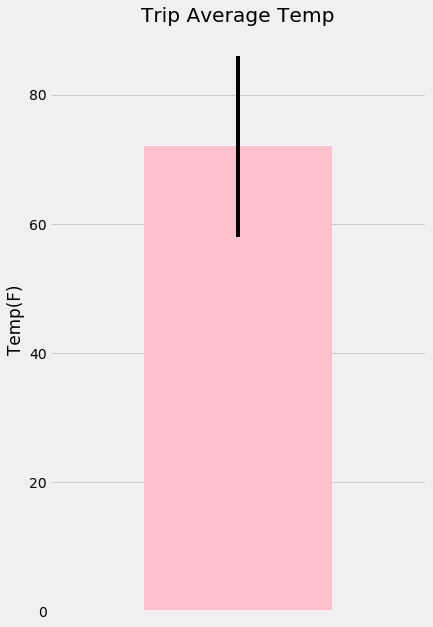

<Figure size 432x288 with 0 Axes>

In [192]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)

df = pd.DataFrame(temps, columns=["t_min", "t_avg", "t_max"])

# plot the average temp 
plt.figure(figsize=(6,10))
ax=df["t_avg"].plot.bar(yerr=(df["t_max"]-df["t_min"]), color="pink")
plt.title("Trip Average Temp")
plt.ylabel("Temp(F)")
ax.axes.get_xaxis().set_visible(False)
plt.show()

# Save the plot
plt.tight_layout()
plt.savefig("Images/avg_temp.png")
plt.show()





In [197]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
start_date = '2017-02-28'
end_date = '2017-03-05'
sel = [func.count(Measurement.prcp),Measurement.station, Station.name, Station.latitude, Station.longitude,Station.elevation]
rainfall=session.query(*sel).filter(Measurement.station==Station.station).\
    group_by(Measurement.station).\
    filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).\
    order_by(func.count(Measurement.prcp).desc()).all()
for r in rainfall:
    print(r)


(6, 'USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0)
(6, 'USC00519281', 'WAIHEE 837.5, HI US', 21.45167, -157.84888999999998, 32.9)
(6, 'USC00516128', 'MANOA LYON ARBO 785.2, HI US', 21.3331, -157.8025, 152.4)
(6, 'USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6)
(5, 'USC00519523', 'WAIMANALO EXPERIMENTAL FARM, HI US', 21.33556, -157.71139, 19.5)
(3, 'USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9)
(2, 'USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 21.5213, -157.8374, 7.0)


In [196]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [214]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

from datetime import datetime

# Set the start and end date of the trip

start_date = '2018-01-01'
end_date = '2018-01-07'

# Use the start and end date to create a range of dates
trip_dates = ["2018-01-01", "2018-01-02", "2018-01-03", "2018-01-04", "2018-01-05", "2018-01-06","2018-01-07"]

# convert strings to datetime
date_list =[datetime.strptime(date, "%Y-%m-%d") for date in trip_dates]
date_list

# Stip off the year and save a list of %m-%d strings
dates = [date.strftime("%m-%d") for date in date_list]
dates





['01-01', '01-02', '01-03', '01-04', '01-05', '01-06', '01-07']

In [215]:
dates = ['01-01', '01-02', '01-03', '01-04', '01-05', '01-06', '01-07']
normals = [daily_normals(date) for date in dates]
normals

[[(62.0, 69.15384615384616, 77.0)],
 [(60.0, 69.39622641509433, 77.0)],
 [(62.0, 68.9090909090909, 77.0)],
 [(58.0, 70.0, 76.0)],
 [(56.0, 67.96428571428571, 76.0)],
 [(61.0, 68.96491228070175, 76.0)],
 [(57.0, 68.54385964912281, 76.0)]]

In [216]:

# flatten the normals list
normal_list = [item for sublist in normals for item in sublist]
normal_list

[(62.0, 69.15384615384616, 77.0),
 (60.0, 69.39622641509433, 77.0),
 (62.0, 68.9090909090909, 77.0),
 (58.0, 70.0, 76.0),
 (56.0, 67.96428571428571, 76.0),
 (61.0, 68.96491228070175, 76.0),
 (57.0, 68.54385964912281, 76.0)]

In [217]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index

normals_df = pd.DataFrame(normal_list, columns=["tmin","tavg", "tmax"], index=trip_dates)
normals_df.index.name="date"
normals_df

,tmin,tavg,tmax
date,,,
2018-01-01,62.0,69.153846,77.0
2018-01-02,60.0,69.396226,77.0
2018-01-03,62.0,68.909091,77.0
2018-01-04,58.0,70.000000,76.0
2018-01-05,56.0,67.964286,76.0
2018-01-06,61.0,68.964912,76.0
2018-01-07,57.0,68.543860,76.0


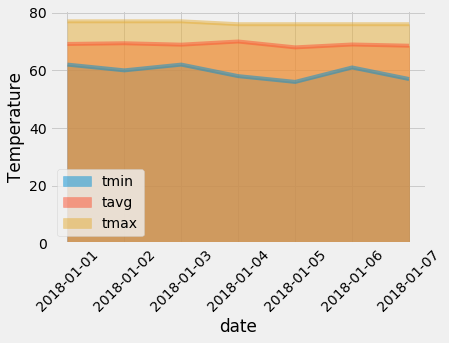

In [220]:
# Plot the daily normals as an area plot with `stacked=False`

normals_df.plot.area(stacked=False)
plt.xticks(rotation=45)
plt.ylabel("Temperature")
plt.show()
